Date
2019-09-07    10.0
2019-09-07     6.0
2019-09-09     5.0
2019-09-10     6.0
2019-09-11     0.0
              ... 
2019-11-09     3.0
2019-11-10     4.0
2019-11-11     2.0
2019-11-12     6.0
2019-11-13     4.0
Name: Available rooms, Length: 68, dtype: float64


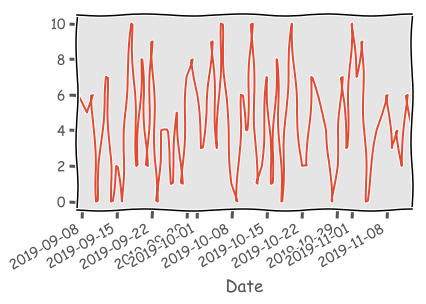

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
plt.style.use('ggplot')
plt.xkcd()
import statsmodels.api as sm

df = pd.read_csv("facility_out.csv")

rooms = pd.Series(df['Available rooms'], dtype='float') 
rooms.index = pd.to_datetime(df['Date'])

rooms.plot()
print(rooms)

In [183]:
# ADF検定（原型列で確認だけ）
res_ctt = sm.tsa.stattools.adfuller(rooms, regression="ctt") # トレンド項あり（２次）、定数項あり
res_ct = sm.tsa.stattools.adfuller(rooms, regression="ct") # トレンド項あり（１次）、定数項あり
res_c = sm.tsa.stattools.adfuller(rooms, regression="c") # トレンド項なし、定数項あり
res_nc = sm.tsa.stattools.adfuller(rooms, regression="nc") # トレンド項なし、定数項なし
print(res_ctt)
print(res_ct)
print(res_c)
print(res_nc)

(-4.441569876125265, 0.007949643483965091, 10, 57, {'1%': -4.587260155027458, '5%': -3.940481738348642, '10%': -3.6194358295399933}, 285.0289855763662)
(-6.159053083668033, 1.0112424502184299e-06, 3, 64, {'1%': -4.10767687789917, '5%': -3.48146914276123, '10%': -3.1684936248779296}, 283.4735876126848)
(-6.1659252973872105, 6.990552804133403e-08, 3, 64, {'1%': -3.53692771987915, '5%': -2.907887369384766, '10%': -2.591493291015625}, 281.5061714608764)
(-0.8497030762546622, 0.34972073125669145, 4, 63, {'1%': -2.6021427210884354, '5%': -1.9459864441485002, '10%': -1.613186489499974}, 295.7857904822698)


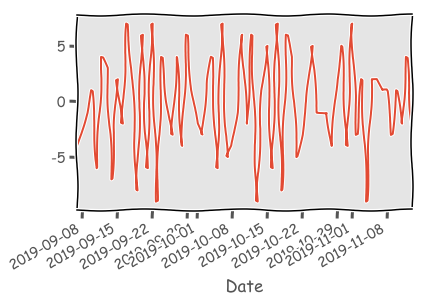

In [184]:
rooms_diff = rooms - rooms.shift() # 差分(1階差)　Pandasのdiff()でpassengers.diff()としてもOK
rooms_diff = rooms_diff.dropna() # 1個できるNaNデータは捨てる
rooms_diff.plot()

In [185]:
import warnings
warnings.filterwarnings('ignore') # 計算警告を非表示

# 自動ARMAパラメータ推定関数
res_selection = sm.tsa.arma_order_select_ic(rooms_diff, ic='aic', trend='nc')
res_selection

{'aic':             0           1           2
 0         NaN  348.799475  349.686207
 1  373.321823  349.749717  345.544222
 2  371.657804  351.747595  347.450172
 3  370.562365  351.100265  354.487631
 4  359.000536  349.791098  349.134905, 'aic_min_order': (1, 2)}

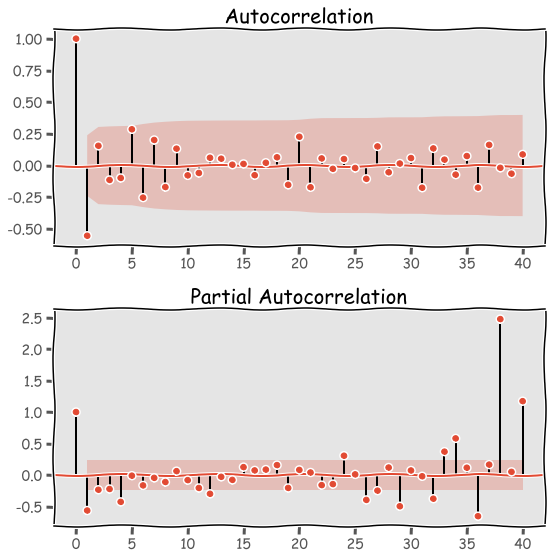

In [186]:
# 差分系列のコレログラム
fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(rooms_diff, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(rooms_diff, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

In [187]:
# SRIMAモデル作成その１
sarimax = sm.tsa.SARIMAX(rooms, 
                        order=(1, 1, 2),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

In [188]:
sarimax_resid = sarimax.resid # モデルの残差成分

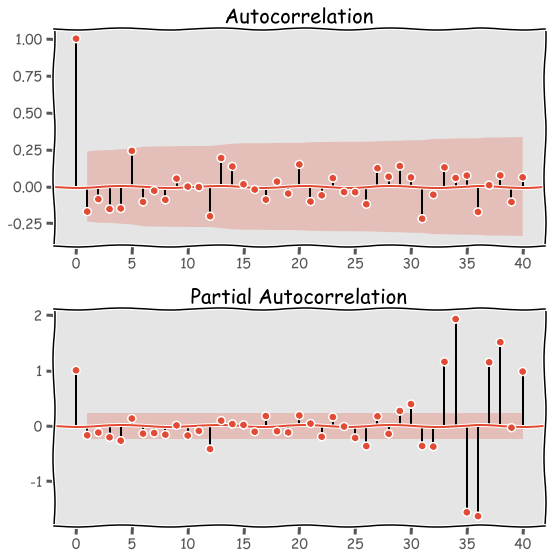

In [189]:
# モデル残差のコレログラム
fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

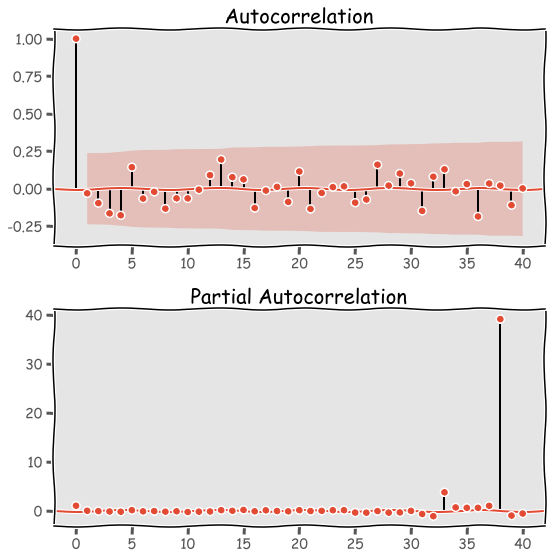

In [190]:
# SRIMAモデル（試しに）季節調整なし
sarimax_noseasonal = sm.tsa.SARIMAX(rooms, 
                        order=(1, 1, 2),
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

sarimax_noseasonal_resid = sarimax_noseasonal.resid # 残差成分

fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_noseasonal_resid, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_noseasonal_resid, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

In [191]:
print(sarimax.aic) # 季節調整あり -> 236
print(sarimax_noseasonal.aic) # 季節調整なし -> 334

236.9652097141942
334.63857338774926


In [192]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                    Available rooms   No. Observations:                   68
Model:             SARIMAX(1, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -112.483
Date:                            Sun, 15 Sep 2019   AIC                            236.965
Time:                                    11:10:24   BIC                            247.098
Sample:                                         0   HQIC                           240.629
                                             - 68                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4549      1.097     -0.415      0.678      -2.606       1.696
ma.L1         -0.6758   3460.054     -0.000      1.000   -6782.257    6780.906
ma.L2         -0.3242   1120.686     -0.000      1.000   -2196.828    2196.179
ar.S.L12      -0.3549      0.385     -0.923      0.356      -1.109       0.399
ma.S.L12      -0.1368      0.430     -0.318      0.751      -0.980       0.707
sigma2        15.1216   5.23e+04      0.000      1.000   -1.03e+05    1.03e+05
===================================================================================
Ljung-Box (Q):                       29.43   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.87   Prob(JB):                         0.68
Heteroskedasticity (H):               0.82   Skew:                             0.22
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [193]:
import warnings
warnings.filterwarnings('ignore') # 警告非表示（収束：ConvergenceWarning）

# パラメータ範囲
# order(p, d, q)
min_p = 1; max_p = 3 # min_pは1以上を指定しないとエラー
min_d = 0; max_d = 1
min_q = 0; max_q = 3 

# seasonal_order(sp, sd, sq)
min_sp = 0; max_sp = 1
min_sd = 0; max_sd = 1
min_sq = 0; max_sq = 1

test_pattern = (max_p - min_p +1)*(max_q - min_q + 1)*(max_d - min_d + 1)*(max_sp - min_sp + 1)*(max_sq - min_sq + 1)*(max_sd - min_sd + 1)
print("pattern:", test_pattern)

sfq = 12 # seasonal_order周期パラメータ
ts = rooms # 時系列データ

test_results = pd.DataFrame(index=range(test_pattern), columns=["model_parameters", "aic"])
num = 0
for p in range(min_p, max_p + 1):
    for d in range(min_d, max_d + 1):
        for q in range(min_q, max_q + 1):
            for sp in range(min_sp, max_sp + 1):
                for sd in range(min_sd, max_sd + 1):
                    for sq in range(min_sq, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            ts, order=(p, d, q), 
                            seasonal_order=(sp, sd, sq, sfq), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        test_results.iloc[num]["model_parameters"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), seasonal_order=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        test_results.iloc[num]["aic"] = sarima.aic
                        print(num,'/', test_pattern-1, test_results.iloc[num]["model_parameters"],  test_results.iloc[num]["aic"] )
                        num = num + 1

# 結果（最小AiC）
print("best[aic] parameter ********")
print(test_results[test_results.aic == min(test_results.aic)])

pattern: 192
0 / 191 order=(1,0,0), seasonal_order=(0,0,0) 383.6596768011458
1 / 191 order=(1,0,0), seasonal_order=(0,0,1) 318.2608982460956
2 / 191 order=(1,0,0), seasonal_order=(0,1,0) 307.734726740594
3 / 191 order=(1,0,0), seasonal_order=(0,1,1) 242.81816262937528
4 / 191 order=(1,0,0), seasonal_order=(1,0,0) 304.2661801095261
5 / 191 order=(1,0,0), seasonal_order=(1,0,1) 300.0290563330954
6 / 191 order=(1,0,0), seasonal_order=(1,1,0) 243.65944737768237
7 / 191 order=(1,0,0), seasonal_order=(1,1,1) 245.37056699686363
8 / 191 order=(1,0,1), seasonal_order=(0,0,0) 343.4822861441892
9 / 191 order=(1,0,1), seasonal_order=(0,0,1) 283.26830575518335
10 / 191 order=(1,0,1), seasonal_order=(0,1,0) 299.224742627989
11 / 191 order=(1,0,1), seasonal_order=(0,1,1) 233.88682181313027
12 / 191 order=(1,0,1), seasonal_order=(1,0,0) 287.4296611702247
13 / 191 order=(1,0,1), seasonal_order=(1,0,1) 279.4587124499667
14 / 191 order=(1,0,1), seasonal_order=(1,1,0) 238.55896768756512
15 / 191 order=(1,

125 / 191 order=(2,1,3), seasonal_order=(1,0,1) 266.9121767538195
126 / 191 order=(2,1,3), seasonal_order=(1,1,0) 242.49626081827353
127 / 191 order=(2,1,3), seasonal_order=(1,1,1) 233.12686491502186
128 / 191 order=(3,0,0), seasonal_order=(0,0,0) 359.71264241489496
129 / 191 order=(3,0,0), seasonal_order=(0,0,1) 303.94302541963935
130 / 191 order=(3,0,0), seasonal_order=(0,1,0) 296.2645650995364
131 / 191 order=(3,0,0), seasonal_order=(0,1,1) 244.79328667784387
132 / 191 order=(3,0,0), seasonal_order=(1,0,0) 293.00872014392235
133 / 191 order=(3,0,0), seasonal_order=(1,0,1) 291.9719463880934
134 / 191 order=(3,0,0), seasonal_order=(1,1,0) 234.77086840085082
135 / 191 order=(3,0,0), seasonal_order=(1,1,1) 235.0530357257128
136 / 191 order=(3,0,1), seasonal_order=(0,0,0) 341.4670856600916
137 / 191 order=(3,0,1), seasonal_order=(0,0,1) 285.32974524258657
138 / 191 order=(3,0,1), seasonal_order=(0,1,0) 296.9943310596651
139 / 191 order=(3,0,1), seasonal_order=(0,1,1) 236.02267580087783
1

In [194]:
test_results.sort_values(by='aic').head() # aic top10

,model_parameters,aic
27,"order=(1,0,3), seasonal_order=(0,1,1)",225.47
31,"order=(1,0,3), seasonal_order=(1,1,1)",225.746
150,"order=(3,0,2), seasonal_order=(1,1,0)",226.242
155,"order=(3,0,3), seasonal_order=(0,1,1)",226.295
95,"order=(2,0,3), seasonal_order=(1,1,1)",227.115


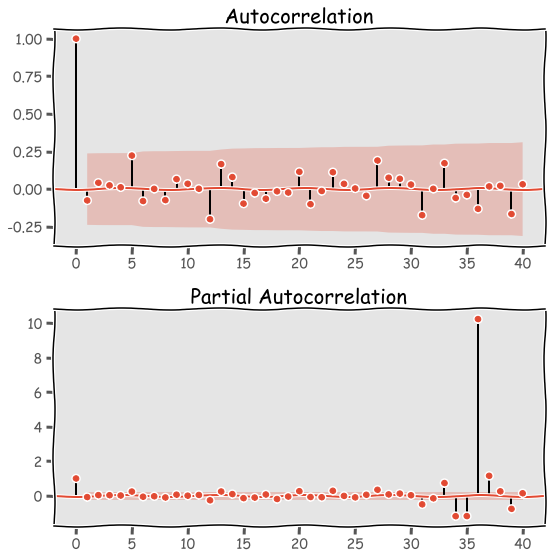

In [269]:
# SRIMAモデル（ちょっとだけパラメータ最適化・総当たりaicベストを適用）
sarimax_optimization = sm.tsa.SARIMAX(rooms, 
                        order=(1, 0, 3),
                        seasonal_order=(0, 1, 1, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

sarimax_optimization_resid = sarimax_optimization.resid # 残差成分

fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_optimization_resid, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_optimization_resid, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

In [290]:
rooms_train = rooms['2019-09-07':'2019-10-22'] # train
print(rooms_train.head())
print(rooms_train.tail())

46
Date
2019-09-07    10.0
2019-09-07     6.0
2019-09-09     5.0
2019-09-10     6.0
2019-09-11     0.0
Name: Available rooms, dtype: float64
Date
2019-10-18     0.0
2019-10-19     6.0
2019-10-20    10.0
2019-10-21     5.0
2019-10-22     2.0
Name: Available rooms, dtype: float64


In [291]:
rooms_test = rooms['2019-10-23': '2019-10-31'] # test
print(rooms_test.head())
print(rooms_test.tail())

9
Date
2019-10-23    2.0
2019-10-24    7.0
2019-10-25    6.0
2019-10-26    5.0
2019-10-27    4.0
Name: Available rooms, dtype: float64
Date
2019-10-27    4.0
2019-10-28    0.0
2019-10-29    2.0
2019-10-30    7.0
2019-10-31    3.0
Name: Available rooms, dtype: float64


In [272]:
sarimax_train = sm.tsa.SARIMAX(rooms_train, 
                        order=(1, 0, 3),
                        seasonal_order=(0, 1, 1, 1),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

In [321]:
sarimax_train_pred = sarimax_train.forecast(len(rooms_test))
print(sarimax_train_pred)
test_pred_ci = sarimax_train.get_forecast(len(rooms_test)).conf_int()
print(test_pred_ci)
print(forecast)

46    3.294554
47    3.937667
48    5.456643
49    4.554479
50    4.527636
51    4.526837
52    4.526813
53    4.526813
54    4.526813
dtype: float64
    lower Available rooms  upper Available rooms
46              -2.914995               9.504103
47              -2.455833              10.331166
48              -0.955354              11.868641
49              -2.152024              11.260982
50              -2.179047              11.234319
51              -2.180872              11.234546
52              -2.181954              11.235581
53              -2.183015              11.236640
54              -2.184075              11.237700
46    3.294554
47    3.937667
48    5.456643
49    4.554479
50    4.527636
51    4.526837
52    4.526813
53    4.526813
54    4.526813
dtype: float64


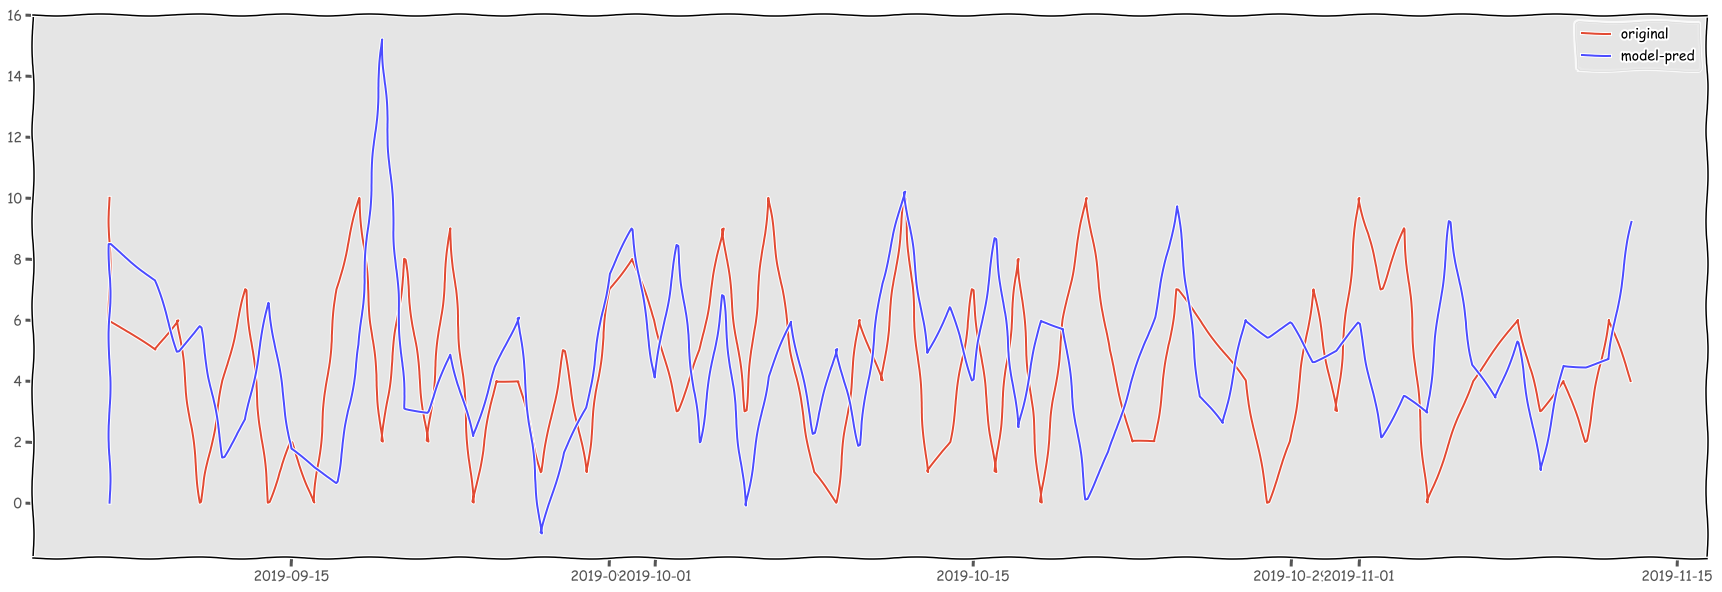

In [320]:
sarimax_pred = sarimax.predict()

plt.figure(figsize=(30, 10))

plt.plot(rooms, label="original")
plt.plot(sarimax_pred, c="b", label="model-pred", alpha=0.7)
plt.legend(loc='best')